In [1]:
import pandas as pd
import numpy as np

import itertools
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 50)

## Exercise 3. Python
Glovo is a three-sided marketplace, where customers can place orders that are prepared by partners and delivered by couriers. In this exercise we will focus on our partners. For the last week, we have been collecting some data about them and we have extracted 7 different tables, that we have provided:

### Dimension tables
- Partners segmented by vertical (data_vertical.csv)
- Partners segmented by business segment (data_business_segments.csv)
- Partners segmented by integration level (data_integrations.csv)
- Partners segmented by country (data_countries.csv)

### Daily metrics tables
- Partners’ orders and connected time (data_orders.csv)
- Partners’ operational metrics (data_operations.csv)
- Partners’ financial metrics (data_finance.csv)

**Join the tables and aggregate the metrics so that you end up with a joint dataset containing one row per partner with all the dimensions and metrics as columns. Using that dataset answer the following questions:**

1. How many active partners do we have in our dataset? (1 point)
2. What is the breakdown per country? And per business segment? (1 point)
3. What percentage of partners have delivered 80% of the orders? (2 points)
4. What is the average delivery time in Portugal (PT)? (2 points)
5. What is the share of orders that integrated partners delivered? (2 points)
6. What is the distribution of the cost per order? Does it follow any known distribution? Is there anything odd in the distribution? (3 points)
7. What is the number of orders compared to connected time? Is there a correlation between the two? (3 points)
8. What are the differences in the metrics for food vs Q-commerce? (3 points)
9. Among all the possible combinations of dimensions (segments), which one has the highest number of partners? (3 points)
10. Summarize your findings in an executive summary.

### Downloading the data

In [3]:
vertical = 'data_vertical.csv' 
business_segment = 'data_business_segments.csv'
integration_level = 'data_integrations.csv'
country = 'data_countries.csv'

orders = 'data_orders.csv'
operational_metrics = 'data_operations.csv'
financial_metrics = 'data_finance.csv'

In [4]:
df_vertical = pd.read_csv(vertical)
df_business_segment = pd.read_csv(business_segment)
df_integration_level = pd.read_csv(integration_level)
df_country = pd.read_csv(country)

df_orders = pd.read_csv(orders)
df_operational_metrics = pd.read_csv(operational_metrics)
df_financial_metrics = pd.read_csv(financial_metrics)

In [5]:
dfs = {
    vertical: df_vertical,
    business_segment: df_business_segment,
    integration_level: df_integration_level,
    country: df_country,
    orders: df_orders,
    operational_metrics: df_operational_metrics,   
    financial_metrics: df_financial_metrics
}

### General information about the data

In [6]:
for name, df in dfs.items():
    print(name, df.shape)
    print(df.info())
    print()
    print()

data_vertical.csv (46208, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46208 entries, 0 to 46207
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   partner_id  46208 non-null  int64 
 1   vertical    46208 non-null  object
dtypes: int64(1), object(1)
memory usage: 722.1+ KB
None


data_business_segments.csv (46208, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46208 entries, 0 to 46207
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   partner_id        46208 non-null  int64 
 1   business_segment  46206 non-null  object
dtypes: int64(1), object(1)
memory usage: 722.1+ KB
None


data_integrations.csv (46208, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46208 entries, 0 to 46207
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   partner_id     46208 non-

### Data wrangling

**According to the requirements, I will aggregate data metrics to make the values available per row unique partner**

In [7]:
# First part of data
df_partners = pd.merge(df_vertical, df_business_segment, on='partner_id')
df_partners = pd.merge(df_partners, df_integration_level, on='partner_id')
df_partners = pd.merge(df_partners, df_country, on='partner_id')

In [8]:
df_partners.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46208 entries, 0 to 46207
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   partner_id        46208 non-null  int64 
 1   vertical          46208 non-null  object
 2   business_segment  46206 non-null  object
 3   is_integrated     46208 non-null  bool  
 4   country           46208 non-null  object
dtypes: bool(1), int64(1), object(3)
memory usage: 1.8+ MB


In [9]:
df_partners.head()

,partner_id,vertical,business_segment,is_integrated,country
0,169385,Food,Local Hero,False,ES
1,230660,Food,Long Tail,False,PT
2,247635,Food,Chain,True,ES
3,341110,Food,Chain,False,ES
4,368335,Food,Long Tail,False,ES


In [10]:
# Second part of data

df_orders_metrics_daily = pd.merge(df_orders, df_operational_metrics, on=['date', 'partner_id'])
df_orders_metrics_daily = pd.merge(df_orders_metrics_daily, df_financial_metrics, on=['date', 'partner_id'])

In [11]:
df_orders_metrics_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190708 entries, 0 to 190707
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   date                      190708 non-null  object 
 1   partner_id                190708 non-null  int64  
 2   orders_daily              190708 non-null  float64
 3   connected_hours           190708 non-null  int64  
 4   avg_delivery_time_min     190708 non-null  float64
 5   avg_preparation_time_min  190708 non-null  float64
 6   avg_order_cost            190708 non-null  float64
 7   avg_order_revenue         190708 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 13.1+ MB


In [12]:
df_orders_metrics_daily.head()

,date,partner_id,orders_daily,connected_hours,avg_delivery_time_min,avg_preparation_time_min,avg_order_cost,avg_order_revenue
0,2021-08-12,169385,1.00,7,18.22,5.52,4.66,11.44
1,2021-08-12,230660,10.00,0,36.89,13.17,5.68,9.39
2,2021-08-12,247635,5.00,0,41.23,22.89,19.92,26.11
3,2021-08-12,341110,3.00,6,38.64,17.56,18.67,26.66
4,2021-08-12,368335,3.00,0,33.68,5.57,17.02,13.38


In [13]:
orders_daily_col = df_orders_metrics_daily['orders_daily']

df_orders_metrics_daily['sum_delivery_time_min'] = df_orders_metrics_daily['avg_delivery_time_min'] * orders_daily_col
df_orders_metrics_daily['sum_preparation_time_min'] = df_orders_metrics_daily['avg_preparation_time_min'] * orders_daily_col
df_orders_metrics_daily['sum_order_cost'] = df_orders_metrics_daily['avg_order_cost'] * orders_daily_col
df_orders_metrics_daily['sum_order_revenue'] = df_orders_metrics_daily['avg_order_revenue'] * orders_daily_col

In [14]:
df_orders_metrics_daily.head()

,date,partner_id,orders_daily,connected_hours,avg_delivery_time_min,avg_preparation_time_min,avg_order_cost,avg_order_revenue,sum_delivery_time_min,sum_preparation_time_min,sum_order_cost,sum_order_revenue
0,2021-08-12,169385,1.00,7,18.22,5.52,4.66,11.44,18.22,5.52,4.66,11.44
1,2021-08-12,230660,10.00,0,36.89,13.17,5.68,9.39,368.88,131.69,56.77,93.91
2,2021-08-12,247635,5.00,0,41.23,22.89,19.92,26.11,206.15,114.46,99.61,130.56
3,2021-08-12,341110,3.00,6,38.64,17.56,18.67,26.66,115.93,52.68,56.01,79.99
4,2021-08-12,368335,3.00,0,33.68,5.57,17.02,13.38,101.05,16.70,51.07,40.15


In [15]:
grouped_df = df_orders_metrics_daily.groupby(by='partner_id', as_index=False).agg(
    n_orders=pd.NamedAgg(column='orders_daily', aggfunc='sum'),
    n_days=pd.NamedAgg(column='orders_daily', aggfunc='count'),
    connected_hours=pd.NamedAgg(column='connected_hours', aggfunc='sum'),
    sum_delivery_time_min=pd.NamedAgg(column='sum_delivery_time_min', aggfunc='sum'),
    sum_preparation_time_min=pd.NamedAgg(column='sum_preparation_time_min', aggfunc='sum'),
    sum_order_cost=pd.NamedAgg(column='sum_order_cost', aggfunc='sum'),
    sum_order_revenue=pd.NamedAgg(column='sum_order_revenue', aggfunc='sum'),
)

df_orders_metrics = pd.DataFrame()
df_orders_metrics['partner_id'] = grouped_df['partner_id']
df_orders_metrics['n_orders'] = grouped_df['n_orders'].astype(np.int64)
df_orders_metrics['n_days'] = grouped_df['n_days'].astype(np.int64)
df_orders_metrics['n_connected_hours'] = grouped_df['connected_hours'].astype(np.int64)

df_orders_metrics['avg_orders_per_day'] = grouped_df['n_orders'] / grouped_df['n_days']
df_orders_metrics['avg_connected_hours_per_day'] = grouped_df['connected_hours'] / grouped_df['n_days']

df_orders_metrics['sum_delivery_time_min'] = grouped_df['sum_delivery_time_min']
df_orders_metrics['avg_delivery_time_min'] = grouped_df['sum_delivery_time_min'] / grouped_df['n_orders']

df_orders_metrics['sum_preparation_time_min'] = grouped_df['sum_preparation_time_min']
df_orders_metrics['avg_preparation_time_min'] = grouped_df['sum_preparation_time_min'] / grouped_df['n_orders']

df_orders_metrics['sum_order_cost'] = grouped_df['sum_order_cost']
df_orders_metrics['avg_order_cost'] = grouped_df['sum_order_cost'] / grouped_df['n_orders']

df_orders_metrics['sum_order_revenue'] = grouped_df['sum_order_revenue']
df_orders_metrics['avg_order_revenue'] = grouped_df['sum_order_revenue'] / grouped_df['n_orders']

In [16]:
df_orders_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46208 entries, 0 to 46207
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   partner_id                   46208 non-null  int64  
 1   n_orders                     46208 non-null  int64  
 2   n_days                       46208 non-null  int64  
 3   n_connected_hours            46208 non-null  int64  
 4   avg_orders_per_day           46208 non-null  float64
 5   avg_connected_hours_per_day  46208 non-null  float64
 6   sum_delivery_time_min        46208 non-null  float64
 7   avg_delivery_time_min        46208 non-null  float64
 8   sum_preparation_time_min     46208 non-null  float64
 9   avg_preparation_time_min     46208 non-null  float64
 10  sum_order_cost               46208 non-null  float64
 11  avg_order_cost               46208 non-null  float64
 12  sum_order_revenue            46208 non-null  float64
 13  avg_order_revenu

In [17]:
df_orders_metrics.head()

,partner_id,n_orders,n_days,n_connected_hours,avg_orders_per_day,avg_connected_hours_per_day,sum_delivery_time_min,avg_delivery_time_min,sum_preparation_time_min,avg_preparation_time_min,sum_order_cost,avg_order_cost,sum_order_revenue,avg_order_revenue
0,910,27,6,78,4.50,13.00,789.45,29.24,287.59,10.65,261.93,9.70,497.21,18.42
1,1310,13,6,16,2.17,2.67,403.38,31.03,116.13,8.93,149.58,11.51,610.89,46.99
2,1935,22,3,0,7.33,0.00,936.27,42.56,312.44,14.20,186.69,8.49,360.59,16.39
3,2285,6,4,27,1.50,6.75,147.88,24.65,46.06,7.68,49.72,8.29,130.71,21.79
4,2310,9,4,0,2.25,0.00,301.73,33.53,80.92,8.99,101.74,11.30,197.79,21.98


### Final table

In [18]:
df_total = pd.merge(df_partners, df_orders_metrics)

In [19]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46208 entries, 0 to 46207
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   partner_id                   46208 non-null  int64  
 1   vertical                     46208 non-null  object 
 2   business_segment             46206 non-null  object 
 3   is_integrated                46208 non-null  bool   
 4   country                      46208 non-null  object 
 5   n_orders                     46208 non-null  int64  
 6   n_days                       46208 non-null  int64  
 7   n_connected_hours            46208 non-null  int64  
 8   avg_orders_per_day           46208 non-null  float64
 9   avg_connected_hours_per_day  46208 non-null  float64
 10  sum_delivery_time_min        46208 non-null  float64
 11  avg_delivery_time_min        46208 non-null  float64
 12  sum_preparation_time_min     46208 non-null  float64
 13  avg_preparation_

In [20]:
df_total.head()

,partner_id,vertical,business_segment,is_integrated,country,n_orders,n_days,n_connected_hours,avg_orders_per_day,avg_connected_hours_per_day,sum_delivery_time_min,avg_delivery_time_min,sum_preparation_time_min,avg_preparation_time_min,sum_order_cost,avg_order_cost,sum_order_revenue,avg_order_revenue
0,169385,Food,Local Hero,False,ES,2,2,18,1.00,9.00,43.87,21.93,26.19,13.10,11.97,5.99,26.31,13.15
1,230660,Food,Long Tail,False,PT,49,7,4,7.00,0.57,1365.30,27.86,441.70,9.01,358.09,7.31,594.56,12.13
2,247635,Food,Chain,True,ES,23,7,0,3.29,0.00,759.12,33.01,414.44,18.02,318.39,13.84,498.37,21.67
3,341110,Food,Chain,False,ES,25,6,36,4.17,6.00,833.55,33.34,269.38,10.78,391.61,15.66,649.94,26.00
4,368335,Food,Long Tail,False,ES,36,7,58,5.14,8.29,1247.12,34.64,398.47,11.07,510.27,14.17,661.23,18.37


In [21]:
df_total.nunique()

partner_id                     46208
vertical                           2
business_segment                   6
is_integrated                      2
country                            4
n_orders                         694
n_days                             7
n_connected_hours                345
avg_orders_per_day               944
avg_connected_hours_per_day      783
sum_delivery_time_min          35353
avg_delivery_time_min          35174
sum_preparation_time_min       28657
avg_preparation_time_min       30476
sum_order_cost                 40009
avg_order_cost                 39999
sum_order_revenue              41451
avg_order_revenue              41601
dtype: int64

## 1. How many active partners do we have in our dataset?

In [22]:
df_total['partner_id'].unique().shape[0]

46208

In [23]:
# All partners in our dataset are active, because they have orders

## 2. What is the breakdown per country? And per business segment?

In [24]:
df_total['country'].value_counts()

ES    22183
IT    10840
UA     6808
PT     6377
Name: country, dtype: int64

In [25]:
round(22183 / 46208,2), round(10840 / 46208,2), round(6808 / 46208,2),round(6377 / 46208,2)

(0.48, 0.23, 0.15, 0.14)

In [26]:
df_total['business_segment'].value_counts()

Long Tail     21273
Chain          7529
Q-Commerce     7110
Local Hero     5475
Big Chain      3730
Sidekick       1089
Name: business_segment, dtype: int64

In [27]:
round(21273 / 46208,2), round(7529 / 46208,2), round(7110 / 46208,2), round(5475 / 46208,2), round(3730 / 46208,2), round(1089 / 46208,2) 

(0.46, 0.16, 0.15, 0.12, 0.08, 0.02)

In [28]:
country_business_segment = df_total.groupby(['country', 'business_segment'], as_index=False)['partner_id'].count()

country_business_segment.sort_values(by='partner_id', ignore_index=True, ascending=False)

,country,business_segment,partner_id
0,ES,Long Tail,10668
1,IT,Long Tail,6002
2,ES,Chain,3405
3,UA,Q-Commerce,2909
4,PT,Long Tail,2710
5,ES,Q-Commerce,2523
6,ES,Big Chain,2431
7,ES,Local Hero,2349
8,UA,Long Tail,1893
9,IT,Chain,1691


## 3. What percentage of partners have delivered 80% of the orders?

In [29]:
tdf = df_total[['partner_id', 'n_orders']].sort_values(by='n_orders', ascending=False)

all_orders_count = np.sum(tdf['n_orders'])

tdf['n_orders_cum_sum'] = np.cumsum(tdf['n_orders'])
tdf['n_orders_cum_frac'] = tdf['n_orders_cum_sum'] / all_orders_count

In [30]:
tdf

,partner_id,n_orders,n_orders_cum_sum,n_orders_cum_frac
34982,1721685,3836,3836,0.00
32965,2064585,2970,6806,0.01
31719,2064535,2778,9584,0.01
44076,1569135,2749,12333,0.01
7485,2235235,2467,14800,0.01
...,...,...,...,...
22753,8585160,1,1261871,1.00
22759,8414260,1,1261872,1.00
22761,6871360,1,1261873,1.00
31957,7347285,1,1261874,1.00


In [31]:
tdf['partner_id'].count()

46208

In [32]:
cnt_80 = tdf[tdf['n_orders_cum_frac'] < 0.8].shape[0] 
cnt_80

9872

In [33]:
assert tdf.iloc[:cnt_80].shape[0] == cnt_80

In [34]:
p = round(9872 / 46208, 2)*100

In [35]:
print(f'{p}% percentage of partners have delivered 80% of orders.')

# Pareto principle :)

21.0% percentage of partners have delivered 80% of orders.


## 4. What is the average delivery time in Portugal (PT)?

In [36]:
df_pt = df_total[df_total['country'] == 'PT']

avg_del =  round(df_pt['sum_delivery_time_min'].sum() / df_pt['n_orders'].sum())

In [37]:
print(f'{avg_del} is the average delivery time in Portugal')

35 is the average delivery time in Portugal


## 5. What is the share of orders that integrated partners delivered?

In [38]:
df_total[['is_integrated', 'n_orders']].groupby('is_integrated', as_index=False).sum()

,is_integrated,n_orders
0,False,537057
1,True,724818


In [39]:
share = round(724818 / (537057+724818), 2)

In [40]:
print(f'{share} is the share of orders that integrated partners delivered')

0.57 is the share of orders that integrated partners delivered


## 6. What is the distribution of the cost per order? Does it follow any known distribution? Is there anything odd in the distribution?

In [41]:
df_total['avg_order_cost'].describe()

count   46208.00
mean        9.90
std         5.79
min         0.00
25%         6.01
50%        10.55
75%        13.16
max        64.64
Name: avg_order_cost, dtype: float64

In [42]:
(df_total['avg_order_cost'] == 0.0).sum()

6062

**I found zeros in distribution, so it could caused by sales promotions or by errors in data**

In [43]:
percent_with_zero = round(6062 / 46208,2) * 100
percent_with_zero

13.0

In [44]:
df_total[df_total['avg_order_cost'] == 0.0][:4]

,partner_id,vertical,business_segment,is_integrated,country,n_orders,n_days,n_connected_hours,avg_orders_per_day,avg_connected_hours_per_day,sum_delivery_time_min,avg_delivery_time_min,sum_preparation_time_min,avg_preparation_time_min,sum_order_cost,avg_order_cost,sum_order_revenue,avg_order_revenue
23,2541160,Food,Big Chain,True,ES,16,6,52,2.67,8.67,1966.42,122.90,0.00,0.00,0.00,0.00,83.79,5.24
27,2939360,Food,Big Chain,True,ES,15,6,84,2.50,14.00,1845.37,123.02,0.00,0.00,0.00,0.00,94.08,6.27
31,3718210,Food,Chain,False,ES,24,7,39,3.43,5.57,2952.15,123.01,0.00,0.00,0.00,0.00,157.20,6.55
35,4253910,Food,Big Chain,True,ES,44,7,48,6.29,6.86,5363.52,121.90,0.00,0.00,0.00,0.00,255.30,5.80


In [45]:
# partner_id for example
df_orders_metrics_daily[df_orders_metrics_daily['partner_id'] == 2541160]

,date,partner_id,orders_daily,connected_hours,avg_delivery_time_min,avg_preparation_time_min,avg_order_cost,avg_order_revenue,sum_delivery_time_min,sum_preparation_time_min,sum_order_cost,sum_order_revenue
23,2021-08-12,2541160,1.00,10,121.60,0.00,0.00,2.79,121.60,0.00,0.00,2.79
410,2021-08-13,2541160,3.00,8,122.07,0.00,0.00,4.20,366.22,0.00,0.00,12.60
1145,2021-08-14,2541160,3.00,4,123.56,0.00,0.00,6.89,370.68,0.00,0.00,20.67
2054,2021-08-15,2541160,5.00,10,123.00,0.00,0.00,5.34,614.98,0.00,0.00,26.70
4722,2021-08-17,2541160,2.00,10,120.72,0.00,0.00,5.21,241.45,0.00,0.00,10.41
18388,2021-08-18,2541160,2.00,10,125.74,0.00,0.00,5.31,251.48,0.00,0.00,10.62


<Axes: ylabel='Frequency'>

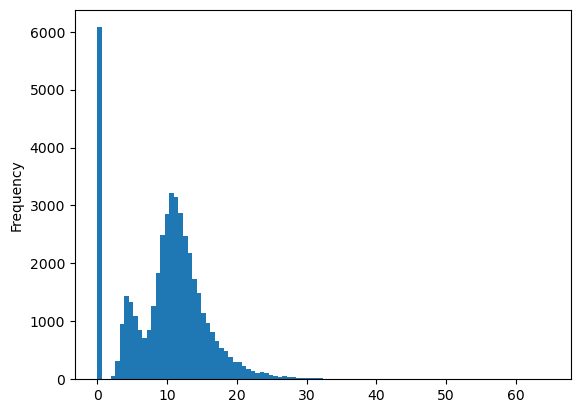

In [46]:
# Distribution of the average order cost
df_total['avg_order_cost'].plot(kind='hist', bins=100)

**Several peaks in the overall picture of distribution, perhaps different countries have different distribution characteristics.**

In [47]:
df_total['country'].unique()

array(['ES', 'PT', 'IT', 'UA'], dtype=object)

country
ES    Axes(0.125,0.11;0.775x0.77)
IT    Axes(0.125,0.11;0.775x0.77)
PT    Axes(0.125,0.11;0.775x0.77)
UA    Axes(0.125,0.11;0.775x0.77)
Name: avg_order_cost, dtype: object

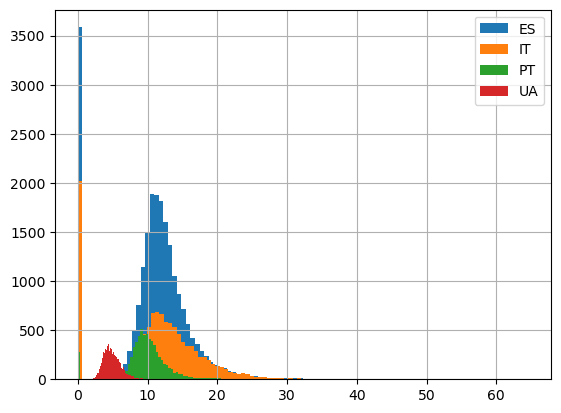

In [48]:
df_total.groupby('country')['avg_order_cost'].hist(bins=100, legend=True)

**I can see, that the distribution of prices in each country described by distribution, similar to Normal, but has a skewness in the left side. It could be Log-normal distribution**

## 7. What is the number of orders compared to connected time? Is there a correlation between the two?

In [49]:
tdf = df_total[['avg_orders_per_day', 'avg_connected_hours_per_day']]

tdf.head()

,avg_orders_per_day,avg_connected_hours_per_day
0,1.00,9.00
1,7.00,0.57
2,3.29,0.00
3,4.17,6.00
4,5.14,8.29


<Axes: xlabel='avg_connected_hours_per_day', ylabel='avg_orders_per_day'>

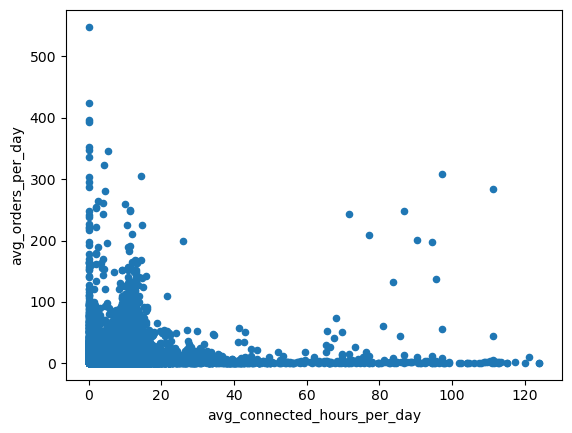

In [50]:
tdf.plot.scatter(x='avg_connected_hours_per_day', y ='avg_orders_per_day')

**As we can see from the graph of the connection of two variables, the correlation value is low**

## 8. What are the differences in the metrics for food vs Q-commerce?

In [51]:
df_total['vertical'].unique()

array(['Food', 'Q-commerce'], dtype=object)

In [52]:
df_food = df_total[df_total['vertical'] == 'Food']
df_qcom = df_total[df_total['vertical'] == 'Q-commerce']

In [53]:
df_food.describe()

,partner_id,n_orders,n_days,n_connected_hours,avg_orders_per_day,avg_connected_hours_per_day,sum_delivery_time_min,avg_delivery_time_min,sum_preparation_time_min,avg_preparation_time_min,sum_order_cost,avg_order_cost,sum_order_revenue,avg_order_revenue
count,39098.00,39098.00,39098.00,39098.00,39098.00,39098.00,39098.00,39098.00,39098.00,39098.00,39098.00,39098.00,39098.00,39098.00
mean,5435147.91,29.09,4.20,27.01,4.86,5.91,1113.91,47.12,339.59,11.49,281.87,10.09,454.45,17.57
std,2350011.03,96.08,2.22,33.55,13.66,5.43,3014.82,32.80,1201.06,7.87,890.46,5.91,1234.91,8.83
min,910.00,1.00,1.00,0.00,1.00,0.00,5.92,2.51,-32.60,-27.77,0.00,0.00,0.00,0.00
25%,3985272.50,3.00,2.00,4.00,1.00,2.00,114.77,28.08,17.13,8.27,15.93,7.10,41.08,11.84
50%,6004547.50,8.00,4.00,17.00,2.00,5.57,307.79,34.09,72.27,11.71,62.68,10.78,125.48,17.08
75%,7301503.75,22.00,6.00,41.00,3.67,9.00,889.98,45.32,238.38,15.11,198.41,13.34,361.21,22.08
max,8721260.00,3836.00,7.00,534.00,548.00,113.00,105142.93,240.55,56317.66,646.17,30418.60,63.49,32047.72,169.38


In [54]:
df_qcom.describe()

,partner_id,n_orders,n_days,n_connected_hours,avg_orders_per_day,avg_connected_hours_per_day,sum_delivery_time_min,avg_delivery_time_min,sum_preparation_time_min,avg_preparation_time_min,sum_order_cost,avg_order_cost,sum_order_revenue,avg_order_revenue
count,7110.00,7110.00,7110.00,7110.00,7110.00,7110.00,7110.00,7110.00,7110.00,7110.00,7110.00,7110.00,7110.00,7110.00
mean,6058662.91,17.50,3.72,26.39,3.26,6.92,568.36,33.15,211.45,12.65,142.92,8.86,185.43,11.71
std,1805924.05,69.42,2.16,67.99,10.33,14.43,1886.56,15.01,559.47,6.39,410.76,4.94,907.45,8.45
min,2710.00,1.00,1.00,0.00,1.00,0.00,7.62,5.02,-105.98,-16.80,0.00,0.00,-22019.30,-11.05
25%,4740622.50,2.00,2.00,0.00,1.00,0.00,60.22,24.26,22.02,8.73,14.10,4.69,20.29,6.79
50%,6486372.50,5.00,3.00,2.00,1.50,0.67,154.57,30.02,60.11,12.13,39.40,8.61,53.71,10.25
75%,7584353.75,14.00,6.00,26.00,2.75,9.33,468.97,38.25,187.14,15.67,122.34,11.90,149.99,14.27
max,8718035.00,2157.00,7.00,848.00,308.14,124.00,62330.57,218.60,14556.40,59.57,15895.65,64.64,31464.36,325.94


I can observe differences in the following indicators and conclude, that Q-commerce direction is new for market 

- Quantity of partners in Q-commerce is much lower, than food delivery **7110 VC 39098**
- Count of orders, providing Q-commerce is  lower, than food delivery **17 VC 29**
- Delivery time in Q-commerce is twice lower, than food delivery segment has 
- Average order's cost and order's revenue in Q-commerce is lower, than in food delivery segment has 

## 9. Among all the possible combinations of dimensions (segments), which one has the highest number of partners?

In [55]:
segments = df_total['business_segment'].unique()
segments

array(['Local Hero', 'Long Tail', 'Chain', 'Big Chain', 'Q-Commerce',
       'Sidekick', nan], dtype=object)

In [56]:
stat_dicts = []

for s1, s2 in itertools.combinations(segments, r=2):
    
    tdf = df_total[(df_total['business_segment'] == s1) | (df_total['business_segment'] == s2)]
    n_partners = tdf.shape[0]

    stat_dicts.append(dict(segment1=s1, segment2=s2, n_partners=n_partners))
stat_df = pd.DataFrame(stat_dicts, columns=['segment1', 'segment2', 'n_partners'])

In [57]:
stat_df.dropna()

,segment1,segment2,n_partners
0,Local Hero,Long Tail,26748
1,Local Hero,Chain,13004
2,Local Hero,Big Chain,9205
3,Local Hero,Q-Commerce,12585
4,Local Hero,Sidekick,6564
6,Long Tail,Chain,28802
7,Long Tail,Big Chain,25003
8,Long Tail,Q-Commerce,28383
9,Long Tail,Sidekick,22362
11,Chain,Big Chain,11259


**Local Hero & Long Tail segments have the highest number of partners**

## 10. Summarize your findings in an executive summary.

**1. We have 46208 active partners in our dataset**

**2.1 Breakdown of partners per country**
- ES  22183, 48%
- IT  10840, 23%
- UA  6808,  15%
- PT  6377,  14%

**2.2 Breakdown of partners per business segment**

- Long Tail   21273, 46%
- Chain       7529, 16%
- Q-Commerce  7110, 15%
- Local Hero  5475, 12%
- Big Chain   3730, 8%
- Sidekick    1089, 2%


**3. 21% Percentage of partners have delivered 80% of orders**

**4. 35 minutes is the average delivery time in Portugal**

**5. 57% is the share of orders that integrated partners delivered**

**6. The distribution of prices in each country described by a distribution,similar to Normal, but has a skewness in the left side. It could be Log-normal distribution**

**6.1 I found Null values in distribution, so it could caused by sales promotions or by errors in quality of data.
13 % of partners have orders with zero values.**

**7. The correlation value between number of orders and connected time is low as we can see from the scatter plot.**

**8. I see differences in the following indicators and conclude, that Q-commerce direction is new for market**
* Quantity of partners in Q-commerce is much lower, than food delivery 7110 VC 39098
* Count of orders, providing Q-commerce is lower, than food delivery 17 VC 29
* Delivery time in Q-commerce is twice lower, than food delivery segment has
* Average order's cost and order's revenue in Q-commerce is lower, than in food delivery segment has

**9. Local Hero & Long Tail segments have the highest number of partners**

**Option 1. Chain & Big Chain segments have the highest business value**

### Option 1. Which combination of dimensions (segments) has the highest business value in your opinion for Glovo and why?

In [58]:
stat_dicts = []

for s1, s2 in itertools.combinations(segments, r=2):
    
    tdf = df_total[(df_total['business_segment'] == s1) | (df_total['business_segment'] == s2)]
    n_partners = tdf.shape[0]
    n_orders = tdf['n_orders'].sum()
    sum_order_cost = tdf['sum_order_cost'].sum()
    sum_order_revenue = tdf['sum_order_revenue'].sum()
    stat_dicts.append(dict(segment1=s1, segment2=s2, n_partners=n_partners, n_orders=n_orders,
                           sum_order_cost=sum_order_cost, sum_order_revenue=sum_order_revenue))
stat_df2 = pd.DataFrame(stat_dicts, columns=['segment1', 'segment2', 'n_partners', 'n_orders',
                                            'sum_order_cost', 'sum_order_revenue'])

In [59]:
stat_df2 = stat_df2.dropna()
stat_df2

,segment1,segment2,n_partners,n_orders,sum_order_cost,sum_order_revenue
0,Local Hero,Long Tail,26748,338552,3259594.17,6237855.05
1,Local Hero,Chain,13004,435267,4220625.68,7726540.51
2,Local Hero,Big Chain,9205,683069,6582354.76,10032722.61
3,Local Hero,Q-Commerce,12585,293954,2643720.74,4602168.64
4,Local Hero,Sidekick,6564,189027,1840549.30,3622209.22
6,Long Tail,Chain,28802,434821,4225097.15,7396893.85
7,Long Tail,Big Chain,25003,682623,6586826.23,9703075.95
8,Long Tail,Q-Commerce,28383,293508,2648192.21,4272521.98
9,Long Tail,Sidekick,22362,188581,1845020.77,3292562.56
11,Chain,Big Chain,11259,779338,7547857.74,11191761.41


In [60]:
stat_df2.sort_values(by='sum_order_revenue', ignore_index=True, ascending=False)[:5]

,segment1,segment2,n_partners,n_orders,sum_order_cost,sum_order_revenue
0,Chain,Big Chain,11259,779338,7547857.74,11191761.41
1,Local Hero,Big Chain,9205,683069,6582354.76,10032722.61
2,Long Tail,Big Chain,25003,682623,6586826.23,9703075.95
3,Big Chain,Q-Commerce,10840,638025,5970952.80,8067389.54
4,Local Hero,Chain,13004,435267,4220625.68,7726540.51


In [61]:
stat_df2.sort_values(by='n_orders', ignore_index=True,  ascending=False)[:5]

,segment1,segment2,n_partners,n_orders,sum_order_cost,sum_order_revenue
0,Chain,Big Chain,11259,779338,7547857.74,11191761.41
1,Local Hero,Big Chain,9205,683069,6582354.76,10032722.61
2,Long Tail,Big Chain,25003,682623,6586826.23,9703075.95
3,Big Chain,Q-Commerce,10840,638025,5970952.80,8067389.54
4,Big Chain,Sidekick,4819,533098,5167781.36,7087430.12


In [62]:
stat_df2.sort_values(by='sum_order_cost', ignore_index=True, ascending=False)[:5]

,segment1,segment2,n_partners,n_orders,sum_order_cost,sum_order_revenue
0,Chain,Big Chain,11259,779338,7547857.74,11191761.41
1,Long Tail,Big Chain,25003,682623,6586826.23,9703075.95
2,Local Hero,Big Chain,9205,683069,6582354.76,10032722.61
3,Big Chain,Q-Commerce,10840,638025,5970952.80,8067389.54
4,Big Chain,Sidekick,4819,533098,5167781.36,7087430.12


**Chain & Big Chain segments have the highest business value, because this combination of partners leading in 3 data slices**